In [243]:
!pip install webdriver_manager
!pip install selenium

In [ ]:
pip install opencv-python

In [244]:
!pip install validators

In [33]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import torch
import os
from dotenv import load_dotenv
import openai 
import anthropic
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display
import google.generativeai
import base64
import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import textwrap
import os
from sklearn.metrics import  accuracy_score,classification_report, confusion_matrix 
from tqdm.notebook import tqdm
import re
import validators
import requests

In [3]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyBE


In [3]:
notebook_dir = os.path.dirname(os.path.abspath("Fnd_notebook.ipynb"))
# IMG_PATH=os.path.join(notebook_dir, 'public_images', 'public_image_set')
IMG_PATH = os.path.join(notebook_dir, '..', 'public_images', 'public_image_set')

In [4]:
google.generativeai.configure()

In [5]:
train_df=pd.read_table("../datasets/raw/multimodal_train.tsv")
val_df=pd.read_table("../datasets/raw/multimodal_validate.tsv")
test_df=pd.read_table("../datasets/raw/multimodal_test_public.tsv")

In [6]:
train_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [7]:
train_df.isnull().sum()

author                   28710
clean_title                  0
created_utc                  0
domain                  167857
hasImage                     0
id                           0
image_url                 1534
linked_submission_id    396143
num_comments            167857
score                        0
subreddit                    0
title                        0
upvote_ratio            167857
2_way_label                  0
3_way_label                  0
6_way_label                  0
dtype: int64

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59319 entries, 0 to 59318
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                56251 non-null  object 
 1   clean_title           59319 non-null  object 
 2   created_utc           59319 non-null  float64
 3   domain                41847 non-null  object 
 4   hasImage              59319 non-null  bool   
 5   id                    59319 non-null  object 
 6   image_url             59163 non-null  object 
 7   linked_submission_id  17472 non-null  object 
 8   num_comments          41847 non-null  float64
 9   score                 59319 non-null  int64  
 10  subreddit             59319 non-null  object 
 11  title                 59319 non-null  object 
 12  upvote_ratio          41847 non-null  float64
 13  2_way_label           59319 non-null  int64  
 14  3_way_label           59319 non-null  int64  
 15  6_way_label        

In [9]:
def class_report(y_test,y_pred):
    accuracy =accuracy_score(y_test,y_pred)
    classification = classification_report(y_test,y_pred)
    print()
    print('=================== Model Evaluation =====================')
    print()
    print("Classification report:" "\n", classification)
    print()
    return accuracy

In [10]:
def conf_matrix(y_test,y_pred,acc):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues', fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(acc)
    plt.title(all_sample_title, size = 25)

In [11]:
def remove_na_rows(df,col):
   return df.dropna(subset=[col])

In [32]:
def subset_df(df,cols):
   return df[cols]

In [19]:
def encode_image(image_source):
    print(image_source)
    if image_source.startswith("http://") or image_source.startswith("https://"):
        # Handle URL
        headers = {"User-Agent": "Mozilla/5.0"}

        response = requests.get(image_source,headers=headers)
        if response.status_code == 200:
            return base64.b64encode(response.content).decode('utf-8')
        else:
            raise Exception(f"Failed to fetch image from URL: {image_source}")
    elif os.path.exists(image_source):
        # Handle local file
        with open(image_source, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    else:
        raise ValueError("Invalid image source. Provide a valid file path or image URL.")

In [43]:
def google_image_search(query, num_images=5):
    # Set up Chrome with WebDriver Manager
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # run in background
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    try:
        # Step 1: Go to Google Images
        driver.get("https://images.google.com/")
        time.sleep(1)

        # Step 2: Enter the search query
        search_box = driver.find_element(By.NAME, "q")
        search_box.send_keys(query)
        search_box.send_keys(Keys.RETURN)
        time.sleep(2)

        # Step 3: Extract image URLs
        image_sections = driver.find_elements(By.XPATH, '//div[@id="search"]//div[@data-attrid="images universal"]')[:num_images]
        
        all_section_images=[]
        for idx, section in enumerate(image_sections, 1):
        # Within each section, find all img tags with src
           imgs = section.find_elements(By.XPATH, './/div[2]//img[@src]')
           image_urls = [img.get_attribute("src") for img in imgs if img.get_attribute("src")]
           all_section_images.append(image_urls)

    

    finally:
        driver.quit()
    return all_section_images   



In [18]:
def is_url(s):
    return validators.url(s)

In [12]:
def get_image_filename(url):
    # Use regular expression to find the part after '.com/' and before '.jpg'
    match = re.search(r'\.com/(.*?)(?=\.[a-zA-Z]{3,4})', url)  # Match part between '.com/' and file extension
    if match:
        return match.group(1).replace('/', '_')  # Replace '/' with '_' for safe filenames
    return None  # Return None if no match is found

In [13]:
##

In [14]:
def match_image_title(df,index,id_col,title_col,scraped_imgs_url):

   # Construct the image path dynamically
   if is_url(df[id_col].iloc[index]):
       image_path_url = get_image_filename(df[id_col].iloc[index])
       image_path = os.path.join(IMG_PATH, f"{image_path_url}.jpg")
   else:    
       image_path = os.path.join(IMG_PATH, f"{df[id_col].iloc[index]}.jpg")
   encoded_image = encode_image(image_path)
   print(encoded_image)
   display(PILImage(encoded_image))

   result = openai.chat.completions.create(
     model="gpt-4-turbo",
     messages = [{
      "role": "user",
      "content": [
        {"type": "text", "text": f"This is title {df[title_col].iloc[index]}"},
        {"type": "text", "text": "Do you think title correctly describes the first image? If you are unsure about it check reference images and match first image with reference images.If it is a person in first image, match first image with reference images and see if they are same person.Respond with yes or no and briefly explain"},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}},
       ] + [
        {"type": "image_url", "image_url": {"url": ref_img}}
        for ref_img in scraped_imgs_url 
      ]
   }],
    max_tokens=200
   )
   return textwrap.fill(result.choices[0].message.content, width=70)

In [15]:
def generate_query(df, title_col, date_col, index):
    date_val = df[date_col].iloc[index]
    print(date_val)
    # Check if the value is numeric (UNIX timestamp)
    if isinstance(date_val, (int, float)):
        dt = datetime.datetime.utcfromtimestamp(date_val)
    elif isinstance(date_val, str):
        try:
            dt = datetime.datetime.strptime(date_val, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            return f"{df[title_col].iloc[index]}"  # Fallback if format is unexpected
    else:
        return f"{df[title_col].iloc[index]}"  # Fallback for unknown types

    year = dt.year
    return f"{df[title_col].iloc[index]} {year}"

In [16]:
# Example usage:
def predict_news_using_similarity(df,index,id_col,title_col,date_col):
   query=generate_query(df,title_col,date_col,index)
   print(query)
   images = google_image_search(f"{query}", num_images=5)
   scraped_imgs_url=[]
   for i, url in enumerate(images, 1):
     scraped_imgs_url.append(url[0])
     # print(f"Image {i}: {url[0]}")
    
   content=match_image_title(df,index,id_col,title_col,scraped_imgs_url)
   print(content) 
   # match = re.match(r"^(Yes|No)[,:\s-]*", content, re.IGNORECASE)
   # if match:
   #      answer = match.group(1).lower()
   #      binary_label = 1 if answer == "yes" else 0
   #      reasoning = content[len(match.group(0)):].strip()
   # else:
   #      binary_label = None
   #      reasoning = content

   #  # Save to the dataframe
   # df.at[index, 'match_label'] = binary_label
   # df.at[index, 'match_reasoning'] = reasoning
   # df.at[index, 'scraped_reference_imgs']=scraped_imgs_url

In [43]:
train_df_cleaned=subset_df(remove_na_rows(train_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])
val_df_cleaned=subset_df(remove_na_rows(val_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])
test_df_cleaned=subset_df(remove_na_rows(test_df,'image_url'),['id','clean_title', 'created_utc', 'image_url','2_way_label'])

In [44]:
id_col='id'
title_col='clean_title'
date_col='created_utc'

In [47]:
img_title_test_pred=test_df_cleaned.copy()
# img_title_test_pred['match_label'] = None
# img_title_test_pred['match_reasoning'] = None
# img_title_test_pred['scraped_reference_imgs'] = None

In [152]:
label_counts = test_df_cleaned['2_way_label'].value_counts()
print(label_counts)

2_way_label
0    35763
1    23400
Name: count, dtype: int64


In [ ]:
for i in tqdm(range(0, 1), desc="Processing Rows"):
    try:
        predict_news_using_similarity(img_title_test_pred,i,id_col,title_col,date_col)
    except Exception as e:
        print(f"Error processing index {i}: {e}")

In [142]:
img_title_test_pred['clean_title'][5]

'the rise of italian fascism circa'

C:\Users\pc\Documents\Journal Work Code\public_images\public_image_set\8g3xtm.jpg


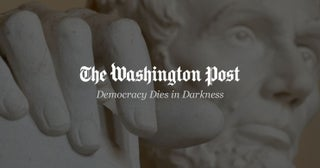

In [144]:

image_path = os.path.join(notebook_dir, 'public_images', 'public_image_set', f"{img_title_test_pred['id'].iloc[6]}.jpg")
encoded_image = encode_image(image_path)
display(Image(image_path))

In [87]:
test_df_process=pd.read_csv("../datasets/processed/img_title_test_pred.csv")

In [88]:
test_df_process.head(10)

,id,clean_title,created_utc,image_url,2_way_label,match_label,match_reasoning,scraped_reference_imgs
0,cozywbv,stargazer,1.425139e+09,http://i.imgur.com/BruWKDi.jpg,0,1.0,"the title ""Stargazer"" correctly describes the ...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
1,ctk61yw,yeah,1.438173e+09,http://i.imgur.com/JRZT727.jpg,0,0.0,the title does not correctly describe the firs...,"['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
2,c0gl7r,pd phoenix car thief gets instructions from yo...,1.560492e+09,https://external-preview.redd.it/1A2_4VwgS8Qd2...,1,1.0,"the title ""PD: Phoenix Car Thief Gets Instruct...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
3,c0xdqy,as trump accuses iran he has one problem his o...,1.560606e+09,https://external-preview.redd.it/9BKRcgvaobpTo...,1,1.0,"the title ""As Trump accuses Iran, he has one p...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
4,7o9rmx,believers hezbollah,1.515139e+09,https://external-preview.redd.it/rbwXHncnjVh51...,0,0.0,"the title ""Believers Hezbollah"" does not corre...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
5,bdfxf1,the rise of italian fascism circa,1.555335e+09,https://preview.redd.it/jpapt6auifs21.jpg?widt...,0,1.0,"the title ""The Rise of Italian Fascism"" does c...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
6,8g3xtm,trumps pick to lead ice who touted surge in im...,1.525131e+09,https://external-preview.redd.it/4-bDBCtwD9WQG...,1,0.0,the title does not correctly describe the firs...,"['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
7,26kwdf,my friend midflip,1.401165e+09,https://external-preview.redd.it/Kz4CnSWPYNMAt...,1,1.0,"the title ""my friend midflip"" correctly descri...","['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
8,2s0xuj,look at this cool iphone case i got the other day,1.420945e+09,https://external-preview.redd.it/m09Q0aKBAlSH8...,0,0.0,the title does not correctly describe the firs...,"['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."
9,cbyjnry,my rope flying off a friend swing,1.377888e+09,http://i.imgur.com/52f5Qlg.jpg,0,0.0,the title does not correctly describe the firs...,"['data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAA..."


In [89]:
test_df_process['match_reasoning'][4]

'the title "Believers Hezbollah" does not correctly describe the\nfirst image if you are seeking strict relevance to visible symbols and\nlogos related directly to Hezbollah. The first image shows a soldier\nin a military stance with no discernible symbols or text conclusively\nlinking him specifically to Hezbollah or its identifiers, such as the\nspecific logo which appears in your third reference image. The\nremaining images include people or symbols directly associated with\nHezbollah (like the logo in the third image or uniforms in other\nimages showing explicit Hezbollah symbols), which are not seen in the\nfirst image.'

In [90]:
test_df_process['image_url'][4]

'https://external-preview.redd.it/rbwXHncnjVh51mrD6D_M3S5PNIC5D8ZVaXB6NaKTno8.jpg?width=320&crop=smart&auto=webp&s=60c81e6a6050bbe469c8407bc38d27078305c2a4'

## AllData

In [23]:
all_data_df=pd.read_csv("../datasets/raw/all_data.csv")
all_data_df = all_data_df.loc[:, ~all_data_df.columns.str.contains('^Unnamed')]

In [24]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015 entries, 0 to 20014
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              20015 non-null  object 
 1   comments            16844 non-null  float64
 2   country             20015 non-null  object 
 3   crawled             16844 non-null  object 
 4   domain_rank         20015 non-null  int64  
 5   id                  4903 non-null   float64
 6   language            16844 non-null  object 
 7   likes               16844 non-null  float64
 8   main_img_url        20015 non-null  object 
 9   ord_in_thread       16844 non-null  float64
 10  participants_count  16844 non-null  float64
 11  published           13514 non-null  object 
 12  replies_count       16844 non-null  float64
 13  shares              16844 non-null  float64
 14  site_url            16844 non-null  object 
 15  spam_score          16844 non-null  float64
 16  text

In [25]:
all_data_df['title'][3]

'Luring Chinese Investors With Trump<U+2019>s Name, and Little Else'

In [26]:
import re
import unicodedata
from bs4 import BeautifulSoup
import string

# Map of common Unicode code points to their ASCII equivalents
unicode_replacements = {
    '2019': "'",  # right single quote
    '2018': "'",  # left single quote
    '201C': '"',  # left double quote
    '201D': '"',  # right double quote
    '2013': '-',  # en dash
    '2014': '-',  # em dash
}

def replace_unicode_placeholders(text):
    def replacer(match):
        code = match.group(1).upper()
        return unicode_replacements.get(code, '')  # Replace known codes or remove
    return re.sub(r'<U\+([0-9A-Fa-f]{4})>', replacer, text)

def clean_text(text, lowercase=True, remove_punct=True, remove_html=True):
    """
    Cleans text by removing HTML, punctuation (including apostrophes and dashes), and normalizing.
    """
    if not isinstance(text, str):
        return ''
    
    # Replace unicode placeholders
    text = replace_unicode_placeholders(text)
    
    # Remove HTML
    if remove_html:
        text = BeautifulSoup(text, "html.parser").get_text()
    
    # Normalize Unicode
    text = unicodedata.normalize("NFKD", text)
    
    # Lowercase
    if lowercase:
        text = text.lower()
    
    # Remove punctuation including apostrophes and dashes
    if remove_punct:
        text = re.sub(r"[^\w\s]", '', text)
    
    # Collapse multiple spaces and strip
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [37]:
def load_and_display_image(url, folder='allData_images'):
    filename = get_image_filename(url)
    if filename:
        image_path = os.path.join(folder, filename + '.jpg')
        if os.path.exists(image_path):
            encoded_image = encode_image(image_path)
            display(IPyImage(image_path))
        else:
            print(f"Image not found at {image_path}")
    else:
        print("Invalid URL format.")
    return None

In [28]:
all_data_df['title'] = all_data_df['title'].fillna('').apply(clean_text)
all_data_df['text'] = all_data_df['text'].fillna('').apply(clean_text)

In [29]:
all_data_df['published'][0]

'2016-11-23 00:45:32'

In [30]:
url = all_data_df['main_img_url'][1]
load_and_display_image(url)

Image not found at allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg


In [33]:
all_data_df_cleaned=subset_df(all_data_df,['id','title', 'text', 'main_img_url','published','type'])

In [34]:
all_data_df_pred=all_data_df_cleaned.copy()
all_data_df_pred['match_label'] = None
all_data_df_pred['match_reasoning'] = None
all_data_df_pred['scraped_reference_imgs'] = None

In [288]:
id_col='main_img_url'
title_col='title'
date_col='published'

In [25]:
IMG_PATH = os.path.join(notebook_dir, '..', 'allData_images')

In [ ]:
for i in tqdm(range(0, 1), desc="Processing Rows"):
    try:
        predict_news_using_similarity(all_data_df_pred,i,id_col,title_col,date_col)
    except Exception as e:
        print(f"Error processing index {i}: {e}")

In [296]:
all_data_df_pred.head()

,id,title,text,main_img_url,published,type,match_label,match_reasoning,scraped_reference_imgs
0,3.0,at donald trumps properties a showcase for a b...,they stood in line at trump tower sometimes up...,https://static01.nyt.com/images/2016/11/23/us/...,2016-11-23 00:45:32,real,1,"the title ""At Donald Trump's Properties, a Sho...","[data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQ..."
1,4.0,trump foundation tells new york it has stopped...,donald j trump s foundation informed attorney ...,https://static01.nyt.com/images/2016/10/18/us/...,2016-10-17 18:46:52,real,None,None,None
2,5.0,donald trump prepares for white house move but...,presidentelect donald j trump won the white ho...,https://static01.nyt.com/images/2016/11/12/us/...,2016-11-12 02:08:39,real,None,None,None
3,6.0,luring chinese investors with trumps name and ...,an investment pitch for a new texas hotel is t...,https://static01.nyt.com/images/2016/10/21/bus...,2016-10-20 22:09:04,real,None,None,None
4,7.0,melania and barron trump wont immediately move...,presidentelect donald j trump s wife melania a...,https://static01.nyt.com/images/2016/11/21/us/...,2016-11-21 01:42:23,real,None,None,None


In [297]:
all_data_df_pred["match_reasoning"][0]

'the title "At Donald Trump\'s Properties, a Showcase for a Brand\nand a President-Elect" correctly describes the first image. The image\nshows a group of people on a balcony of a building that appears to be\npart of a Trump property, as indicated by the emblem visible on the\nbalcony which is associated with Trump\'s brand. This setting aligns\nwith the description of the property being a showcase for Trump\'s\nbrand, and it captures the atmosphere during a period when he was\nPresident-Elect.'

In [290]:
all_data_df_pred["title"][0] 

'at donald trumps properties a showcase for a brand and a presidentelect'

In [24]:
# all_data_df_pred.to_csv('datasets/processed/all_data_df_pred.csv')

../allData_images\images_2016_10_30_nyregion_30TRUMPHEIGHTS-COMBO_30TRUMPHEIGHTS-COMBO-master768.jpg


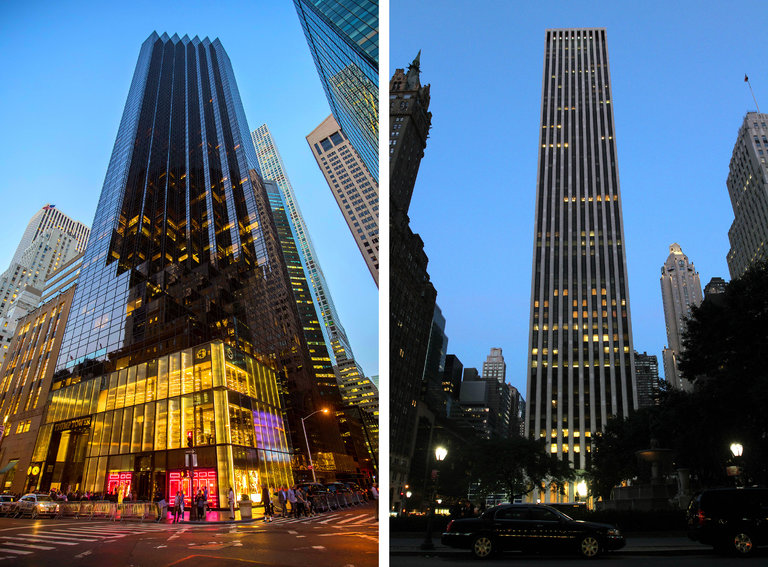

In [97]:
url = all_data_df['main_img_url'][8]
load_and_display_image(url,folder='../allData_images')

In [21]:
def load_and_display_image(url, folder='allData_images'):
    filename = get_image_filename(url)
    if filename:
        image_path = os.path.join(folder, filename + '.jpg')
        if os.path.exists(image_path):
            encoded_image = encode_image(image_path)
            print(image_path)
            display(Image(image_path))
        else:
            print(f"Image not found at {image_path}")
    else:
        print("Invalid URL format.")
    return None

In [64]:
from sentence_transformers import SentenceTransformer, util
import io

In [74]:
import base64
import io
from PIL import Image as PILImage
import os

def get_pil_image(input_data):
    """
    If input_data is a base64 string (with or without data URI), decode and return Pillow Image.
    If input_data is a valid image file path, open and return Pillow Image.
    """
    # Check if input_data looks like base64 (starts with 'data:image' or very long string without a file path)
    if isinstance(input_data, str):
        if input_data.startswith("data:image") or len(input_data) > 100:
            # Likely base64 string
            if input_data.startswith("data:image"):
                input_data = input_data.split(",", 1)[1]
            try:
                image_data = base64.b64decode(input_data)
                return PILImage.open(io.BytesIO(image_data))
            except Exception as e:
                print("Error decoding base64 image:", e)
                raise
        elif os.path.isfile(input_data):
            # Treat as image file path
            try:
                return PILImage.open(input_data)
            except Exception as e:
                print("Error opening image file:", e)
                raise
        else:
            raise ValueError("Input string is neither a valid file path nor a base64 image string.")
    else:
        raise TypeError("Input must be a base64 string or a file path string.")


In [81]:
all_data_df['title'][1]
# load_and_display_image(url,folder='../allData_images')

'trump foundation tells new york it has stopped soliciting after state order'

../allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg


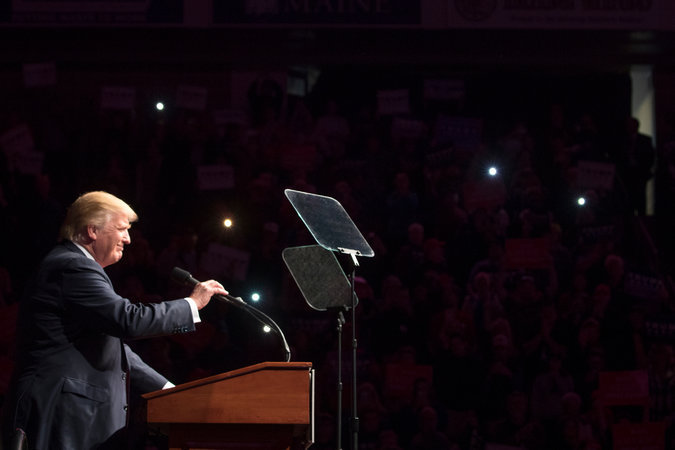

In [98]:
url = all_data_df['main_img_url'][1]
load_and_display_image(url,folder='../allData_images')

In [61]:
url

'https://static01.nyt.com/images/2016/11/12/us/12tower1/12tower1-master768.jpg'

In [104]:
model = SentenceTransformer('clip-ViT-B-32')

#Encode an image:
img_emb = model.encode(get_pil_image("../allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg"))
ref1=get_pil_image(all_ref[0][0])
ref2=get_pil_image(all_ref[1][0])
ref3=get_pil_image(encode_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQAhvsuDHE6Da5t0zUKw7G2hoqp-BWzHm1PHA&s"))
#Encode text descriptions
ref_emb = model.encode([ref1,ref2,ref3,'trump foundation tells new york it has stopped soliciting after state order'])

#Compute cosine similarities 
cos_scores = util.cos_sim(img_emb, ref_emb)
print(cos_scores)

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
C:\Users\pc\AppData\Local\Temp\ipykernel_27292\2434723601.py:4: SyntaxWarning: invalid escape sequence '\i'
  img_emb = model.encode(get_pil_image("../allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg"))


https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQAhvsuDHE6Da5t0zUKw7G2hoqp-BWzHm1PHA&s
tensor([[0.8832, 0.7985, 0.7348, 0.2600]])


In [84]:
all_ref=google_image_search("trump foundation tells new york it has stopped soliciting after state order",3)

In [45]:
len(all_ref)

3

In [50]:
from insightface.app import FaceAnalysis
import cv2
import base64
import numpy as np
from PIL import Image
import io

# Load model
app = FaceAnalysis()
app.prepare(ctx_id=0)  # Use ctx_id=-1 if no GPU available

# Convert base64 string to OpenCV image
def base64_to_cv2(base64_str):
    if base64_str.startswith("data:image"):
        base64_str = base64_str.split(",", 1)[1]
    image_data = base64.b64decode(base64_str)
    pil_img = Image.open(io.BytesIO(image_data))
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

# Detect faces and draw bounding boxes
def draw_face_boxes(base64_img):
    img = base64_to_cv2(base64_img)
    faces = app.get(img)

    if not faces:
        print("No face found")
        return img

    for face in faces:
        bbox = face.bbox.astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # Check if landmarks exist
        if face.landmark is not None:
            for (x, y) in face.landmark.astype(int):
                cv2.circle(img, (x, y), 2, (0, 0, 255), -1)


    return img

# Example usage:
img_with_boxes = draw_face_boxes(all_ref[2][0])

# Show image in OpenCV window (optional)
# cv2.imshow("Faces", img_with_boxes)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Or save image to file
cv2.imwrite("faces_detected.jpg", img_with_boxes)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det

True

In [75]:
def base64_to_ipy_image(base64_str):
    if base64_str.startswith("data:image"):
        base64_str = base64_str.split(",", 1)[1]
    return IPyImage(data=base64.b64decode(base64_str))

In [49]:
base64_to_ipy_image(all_ref[2][0])

NameError: name 'base64_to_ipy_image' is not defined

In [ ]:
all_ref[1][0]

In [ ]:
encode_image("../allData_images\images_2016_10_18_us_18fd-trumpfoundation_18fd-trumpfoundation-master675.jpg")

In [56]:
import cv2
import numpy as np
import base64
from insightface import model_zoo
from PIL import Image
import io
from sklearn.metrics.pairwise import cosine_similarity




detector = FaceAnalysis()

recognizer = FaceAnalysis(name='MS1MV2')
recognizer.prepare(ctx_id=0)

def base64_to_cv2(base64_str):
    if base64_str.startswith("data:image"):
        base64_str = base64_str.split(",", 1)[1]
    img_data = base64.b64decode(base64_str)
    pil_img = Image.open(io.BytesIO(img_data))
    img_cv = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    return img_cv

def align_face(img):
    faces = detector.get(img)
    if faces is None or len(faces) == 0:
        print("No faces detected")
        return None
    
    bbox, landmarks = faces[0][0:4], faces[0][5:15].reshape((5, 2))
    aligned_face = recognizer.get_aligned_face(img, landmarks)
    return aligned_face

def get_embedding_from_base64(base64_img):
    img = base64_to_cv2(base64_img)
    aligned = align_face(img)
    if aligned is None:
        return None
    embedding = recognizer.get_embedding(aligned)
    return embedding

# Compute similarity between two base64 images
def compute_similarity(base64_img1, base64_img2):
    emb1 = get_embedding_from_base64(base64_img1)
    emb2 = get_embedding_from_base64(base64_img2)
    if emb1 is None or emb2 is None:
        print("Failed to get embeddings for one or both images")
        return None
    sim = cosine_similarity([emb1], [emb2])[0][0]
    return sim

# Example usage:
similarity = compute_similarity(all_ref[1][0], all_ref[2][0])
print("Cosine similarity:", similarity)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\pc/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
downloa

RuntimeError: Failed downloading url https://github.com/deepinsight/insightface/releases/download/v0.7/MS1MV2.zip